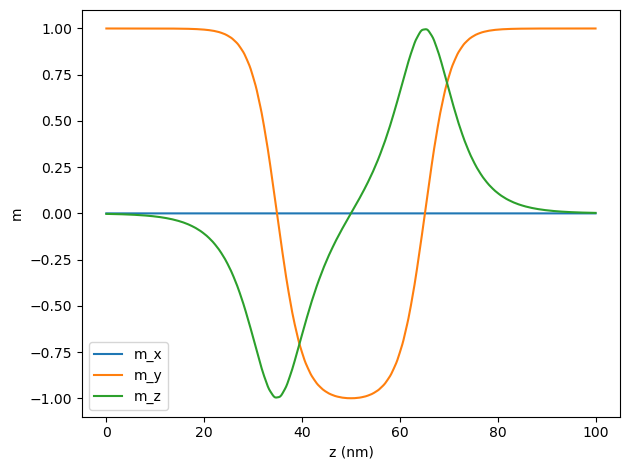

In [9]:
'''
We plot the magnetization profile along a line parallel to the z-axis passing through the skyrmion center. This skyrmion is stabilized by 
interfacial DMI, whose effective field can be written as (see, e.g., Phys. Rev. Lett. 120, 067201 (2018)):

H_DMI = -2 D/ mu_0 M_s ( n (\nabla \cdot m) - \nabla (n\cdot m))

'''

from pathlib import Path
import h5py
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt


# -------- helpers --------
def load_h5(fname, geom="Mesh/Grid/geometry", topo="Mesh/Grid/topology", field="Function/f/0"):
    with h5py.File(fname, "r") as h5:
        points = np.asarray(h5[geom], dtype=float)
        topo   = np.asarray(h5[topo], dtype=np.int64)
        m      = np.asarray(h5[field], dtype=float)

    if points.shape[1] != 3 or topo.shape[1] != 4 or m.shape[1] != 3:
        raise ValueError(f"Shapes inesperadas: points{points.shape}, topo{topo.shape}, m{m.shape}")
    if m.shape[0] != points.shape[0]:
        raise ValueError(f"m no coincide con #puntos: m{m.shape[0]} vs points{points.shape[0]}")
    return points, topo, m


def make_grid(points, topo, m):
    nc = topo.shape[0]
    cells = np.c_[np.full(nc, 4, np.int64), topo].ravel()
    celltypes = np.full(nc, pv.CellType.TETRA, np.uint8)
    grid = pv.UnstructuredGrid(cells, celltypes, points)
    grid.point_data["m"] = m
    return grid


def sample_along_line(grid, p0, p1, npts=200):

    p0 = np.asarray(p0, dtype=float)
    p1 = np.asarray(p1, dtype=float)

    line = pv.Line(p0, p1, resolution=npts)
    sampled = line.sample(grid)


    mline = sampled["m"]
    mask = np.isfinite(mline).all(axis=1)


    pts = sampled.points
    s = np.linalg.norm(pts - pts[0], axis=1)

    return s[mask], mline[mask]


# -------- main --------
fname = "relax/Relax.h5"
npts = 400

points, topo, m = load_h5(fname)
grid = make_grid(points, topo, m)


p0 = (0.0, 39.0, 100.0)
p1 = (0.0, 39.0, 200.0)

s, mline = sample_along_line(grid, p0, p1, npts=npts)

mx, my, mz = mline.T
mnorm = np.linalg.norm(mline, axis=1)

plt.plot(s, mx, label="m_x")
plt.plot(s, my, label="m_y")
plt.plot(s, mz, label="m_z")


plt.xlabel("z (nm)")
plt.ylabel("m")
plt.legend()
plt.tight_layout()
plt.show()

We note that the relaxed (stabilized) skyrmion is not perfectly symmetric, as can be visualized in ParaView. This asymmetry arises from the DMI contribution, which depends on terms proportional to spatial gradients (e.g., $\nabla n$)

As a numerical consistency check, we also performed simulations in which we neglect the contribution proportional to $\nabla n$. In this case, the DMI effective field reads:

$H_{DMI} = -2 D/ \mu_0 M_s ( n (\nabla \cdot m) - (\nabla \cdot m)^{T} n)$

This DMI effective field expression has been implemented in Boris. We compared the corresponding relaxed states against Boris using a cell size of 0.25x0.25x0.5 $nm^3$ (the skyrmion diameter is sensitive to the discretization). In this simplified setting, the skyrmion relaxes to an approximately circularly symmetric configuration.


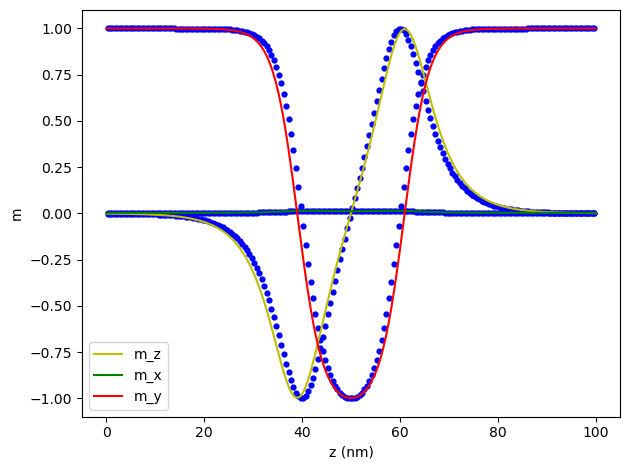

In [7]:
from pathlib import Path
import h5py
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt


def load_h5(fname, geom="Mesh/Grid/geometry", topo="Mesh/Grid/topology", field="Function/f/0"):
    with h5py.File(fname, "r") as h5:
        points = np.asarray(h5[geom], dtype=float)
        topo   = np.asarray(h5[topo], dtype=np.int64)
        m      = np.asarray(h5[field], dtype=float)

    if points.shape[1] != 3 or topo.shape[1] != 4 or m.shape[1] != 3:
        raise ValueError(f"Shapes inesperadas: points{points.shape}, topo{topo.shape}, m{m.shape}")
    if m.shape[0] != points.shape[0]:
        raise ValueError(f"m no coincide con #puntos: m{m.shape[0]} vs points{points.shape[0]}")
    return points, topo, m


def make_grid(points, topo, m):
    nc = topo.shape[0]
    cells = np.c_[np.full(nc, 4, np.int64), topo].ravel()
    celltypes = np.full(nc, pv.CellType.TETRA, np.uint8)
    grid = pv.UnstructuredGrid(cells, celltypes, points)
    grid.point_data["m"] = m
    return grid


def sample_along_line(grid, p0, p1, npts=200):

    p0 = np.asarray(p0, dtype=float)
    p1 = np.asarray(p1, dtype=float)

    line = pv.Line(p0, p1, resolution=npts)
    sampled = line.sample(grid)

    
    mline = sampled["m"]
    mask = np.isfinite(mline).all(axis=1)


    pts = sampled.points
    s = np.linalg.norm(pts - pts[0], axis=1)

    return s[mask], mline[mask]


# -------- main --------
fname = "relaxtest/Relax.h5"
npts = 400

points, topo, m = load_h5(fname)
grid = make_grid(points, topo, m)

p0 = ( 0.125, 39.625, 100.0)
p1 = ( 0.125, 39.625, 200.0)

s, mline = sample_along_line(grid, p0, p1, npts=npts)

mx, my, mz = mline.T
mnorm = np.linalg.norm(mline, axis=1)


plt.plot(s, mz, label="m_z", color = 'y')
plt.plot(s, mx, label="m_x", color = 'green')
plt.plot(s, my, label="m_y", color = 'red')

# Compare with Boris (blue circle)

plt.scatter(posk[:,2],magsk[:,2],color = 'b', s =12)
plt.scatter(posk[:,2],magsk[:,1],color = 'b', s =12)
plt.scatter(posk[:,2],magsk[:,0],color = 'b', s =12)






plt.xlabel("z (nm)")
plt.ylabel("m")
plt.legend()
plt.tight_layout()
plt.show()
